# Import

In [1]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"Error")

torch version: 2.0.0
torchvision version: 0.15.0


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Lambda
from torch.optim import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score, balanced_accuracy_score

import pandas as pd
import numpy as np
import pathlib
from PIL import Image
import os
from tqdm.auto import tqdm
import set_custom_seed

try:
    from torchinfo import summary
except:
    print('torchinfo not installed.')


c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Setup Device Agnostic code


In [3]:
# Setup device agnostic code, use CUDA if avaliable
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data exploration

In [4]:
data_label_train = pd.read_csv('../data/trainlabels.txt', sep=' ', header=0)
data_label_val = pd.read_csv('../data/vallabels.txt', sep=' ', header=0)
data_label_test = pd.read_csv('../data/testlabels.txt', sep=' ', header=0)

print(data_label_train.head())

                    image  label
0   train/image_59270.jpg      0
1  train/image_150277.jpg      0
2  train/image_432208.jpg      0
3  train/image_423122.jpg      0
4  train/image_344581.jpg      0


In [5]:
data_label_train

,image,label
0,train/image_59270.jpg,0
1,train/image_150277.jpg,0
2,train/image_432208.jpg,0
3,train/image_423122.jpg,0
4,train/image_344581.jpg,0
...,...,...
5182,train/image_323102.jpg,0
5183,train/image_94004.jpg,0
5184,train/image_459476.jpg,1
5185,train/image_241550.jpg,0


Train data
0    4342
1     845
Name: label, dtype: int64

Val data
0    1073
1     224
Name: label, dtype: int64

Test data
0    1340
1     282
Name: label, dtype: int64



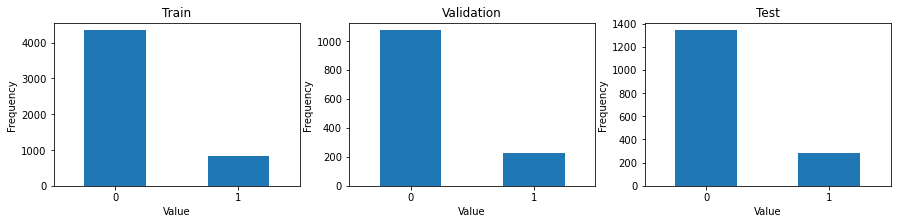

In [6]:
print(f'Train data\n{data_label_train.label.value_counts()}\n')
print(f'Val data\n{data_label_val.label.value_counts()}\n')
print(f'Test data\n{data_label_test.label.value_counts()}\n')

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Plot the train set
data_label_train.label.value_counts().plot.bar(ax=axes[0], rot=0)
axes[0].set_title('Train')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot the validation set
data_label_val.label.value_counts().plot.bar(ax=axes[1], rot=0)
axes[1].set_title('Validation')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Plot the test set
data_label_test.label.value_counts().plot.bar(ax=axes[2], rot=0)
axes[2].set_title('Test')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

# Display the subplots
plt.show()

From data exploration, we can see that the data is imbalanced with positive class being the minority class.

# Create custom dataset and data loader

Using my custom function to create data loader. Please see explanation in the files.

In [7]:
#Setup directory
train_dir = '../data/train/'
val_dir = '../data/val/'
test_dir = '../data/test/'

#set up class mapping
classes = [0, 1]  #  class label
label_to_name = {0:"benign", 1: "malignant"}  # Mapping 

In [8]:
#See the path to all image in the test directorty
test_path = list(pathlib.Path(test_dir).glob("*.jpg"))
test_path

[WindowsPath('../data/test/image_100160.jpg'),
 WindowsPath('../data/test/image_100231.jpg'),
 WindowsPath('../data/test/image_100524.jpg'),
 WindowsPath('../data/test/image_100651.jpg'),
 WindowsPath('../data/test/image_100779.jpg'),
 WindowsPath('../data/test/image_101329.jpg'),
 WindowsPath('../data/test/image_101460.jpg'),
 WindowsPath('../data/test/image_101505.jpg'),
 WindowsPath('../data/test/image_101614.jpg'),
 WindowsPath('../data/test/image_101746.jpg'),
 WindowsPath('../data/test/image_101881.jpg'),
 WindowsPath('../data/test/image_102119.jpg'),
 WindowsPath('../data/test/image_102501.jpg'),
 WindowsPath('../data/test/image_102863.jpg'),
 WindowsPath('../data/test/image_103461.jpg'),
 WindowsPath('../data/test/image_103830.jpg'),
 WindowsPath('../data/test/image_104323.jpg'),
 WindowsPath('../data/test/image_10444.jpg'),
 WindowsPath('../data/test/image_104725.jpg'),
 WindowsPath('../data/test/image_104874.jpg'),
 WindowsPath('../data/test/image_105228.jpg'),
 WindowsPath('

In [9]:
#Count the number of image in train directory
len(list(pathlib.Path(train_dir).glob("*.jpg")))

6877

Dimension is (50, 50)


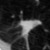

In [10]:
#See an image
test_image = Image.open(test_path[0])
print(f'Dimension is {np.array(test_image).shape}')
test_image

Now we are going to prepare the data loader

In [11]:
# define transform

# Example of using trivial augment in compose
# train_transforms_1 = transforms.Compose([ #compose is used to compile all transform step
#     # Resize the images  
#     transforms.Resize((64, 64)),
    
#     transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
#     transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
# ])

train_transforms = transforms.Compose([ #compose is used to compile all transform step
    # Resize the images
    transforms.Resize((50, 50)),
    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])


# Don't need to perform augmentation on the val, test data
val_transforms = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor()
])



In [12]:
#Data preparation
import data_setup


train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, class_labels = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               val_dir = val_dir,                
                                                                               test_dir=test_dir,
                                                                               train_transform=train_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               val_transform=val_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               test_transform=test_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               train_label_df = data_label_train,
                                                                               val_label_df = data_label_val,
                                                                               test_label_df = data_label_test,
                                                                               class_map = label_to_name,                
                                                                              batch_size=32) # set mini-batch size to 32

train_dataloader, val_dataloader, test_dataloader, class_labels

(<torch.utils.data.dataloader.DataLoader at 0x22ec180ca00>,
 [0, 1])

Number of batches in train set:162
Number of batches in val set:41
Number of batches in test set:51
Class labels: [0, 1]

Getting random image from train data at index 1202


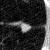

Dimension of an image tensor: torch.Size([1, 50, 50])
Label of data: 1
Tensor of data: tensor([[[0.0706, 0.0824, 0.0314,  ..., 0.7843, 0.7647, 0.8196],
         [0.0706, 0.0824, 0.0000,  ..., 0.9098, 0.9294, 0.8941],
         [0.0078, 0.1098, 0.0510,  ..., 0.9882, 0.9020, 0.8667],
         ...,
         [0.1020, 0.0980, 0.1804,  ..., 0.9686, 0.8392, 0.6078],
         [0.0902, 0.1059, 0.3333,  ..., 0.9294, 0.7569, 0.6510],
         [0.0863, 0.0902, 0.2471,  ..., 1.0000, 0.9176, 0.7373]]])
Path of data: train/image_214850.jpg
Data type: torch.float32


In [13]:
#Count the number of batch
print(f'Number of batches in train set:{len(train_dataloader)}')
print(f'Number of batches in val set:{len(val_dataloader)}')
print(f'Number of batches in test set:{len(test_dataloader)}')
print(f'Class labels: {class_labels}')

#Getting a random sample from the training set
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random image from train data at index {random_number}')
single_image = train_data[random_number][0]
single_image_toPil = transforms.ToPILImage() 
img =  single_image_toPil(single_image)  
display(img)
print(f'Dimension of an image tensor: {train_data[random_number][0].size()}')
print(f'Label of data: {train_data[random_number][1]}')
print(f'Tensor of data: {train_data[random_number][0]}')
print(f'Path of data: {train_data[random_number][2]}')
print(f'Data type: {train_data[random_number][0].dtype}')

In [14]:
# Since the data is imbalance, we will use class weighting
# The calculation of classweights is according to the argument pos_weight in the loss function.
n0 = data_label_train.label.value_counts()[0] #amount of 0 in train set
n1 = data_label_train.label.value_counts()[1] #amount of 1 in train set
weight_1 = n0/n1
class_weights = torch.tensor([weight_1]).to(device) #convert to tensor and send to device

#Initilize empty model-resutls list to store model results and comapre later
model_results = []

The data is ready

# Model 1 - SimpleCNN_V1

Now we will try a very very simple CNN.

## Preparation

In [15]:
set_custom_seed.set_seed(6)
class SimpleCNN_v1(nn.Module):
    def __init__(self):
        super(SimpleCNN_v1, self).__init__()
        
        # First convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Second convolutional block
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Classifier block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 11 * 11, 1)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
  
#Instantiate model    
model_0 = SimpleCNN_v1().to(device) #don't forget to send to device 

#See model summary with torchinfo
# do a test pass through of an example input size 
summary(model_0, input_size=[1, 1, 50, 50], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) 

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
SimpleCNN_v1                             --                        [1, 1, 50, 50]            [1, 1]                    --                        --                        True
├─Sequential: 1-1                        --                        [1, 1, 50, 50]            [1, 16, 24, 24]           --                        --                        True
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 50, 50]            [1, 16, 48, 48]           160                       368,640                   True
│    └─ReLU: 2-2                         --                        [1, 16, 48, 48]           [1, 16, 48, 48]           --                        --                        --
│    └─MaxPool2d: 2-3                    2                         [1, 16, 48, 48]           [1, 16, 24, 24]         

This model utilize  2 convolution layer. The first convolution block accept the input [1,50,50] and output 16 features map with kernel size 3, padding 0 (default) and stride 1 (default).

Using the formular: <br> **Output size = ((input_dim - kernel_size + 2 * padding) / stride) + 1** <br> 
We get the output dimension of 48 for both wideth and height. <br>

For the MaxPool2d layer, the pooling kernel size is 2 and the stride is 2, which will reduce the dimension by half. <br> 

For the next Conv2d layer, since we now have 16 features map, the input channel is 16 and we output another 32 features map with this layer. Usinf the above formular, the height and width became 22. We pass it to ReLU and to the MaxPool2D again. The MaxPool2d further reduce the dimension to 11. Finally, we flatten it and put it to dense layer with 32x11x11 features.

Testing the model on single data

In [16]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch, path_single = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model. In this case use the first image from test set. 
#the extradimension is batch size. So we unsqueeze to add batch size dimension. In this case, the batch size is 1.

random_number = np.random.randint(0,32)

print(f'Random sample number: {random_number}')
img_single, label_single = img_batch[random_number].unsqueeze(dim=0), label_batch[random_number]
print(f"Single image shape before unsqueeze: {img_batch[random_number].shape}.\nIt is [color_channels, height, width].\n")
print(f"Single image shape: {img_single.shape}.\nIt is [batch_size,color_channels, height, width].\n")

print(f'The image tensor is:{img_single} \n')


# 3. Perform a forward pass on a single image
model_0.eval() #set to eval
with torch.inference_mode(): #set to inference mode
    pred = model_0(img_single.to(device)) #predict the image on GPU
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n") #Print the logit
print(f"Output prediction probabilities:\n{torch.sigmoid(pred)}\n") #Print the probability for each class
print(f"Output prediction label:\n{torch.round(torch.sigmoid(pred))}\n") #Select the maximum probability as predicted label.
print(f"Actual label:\n{label_single}") #Get the actual label.


Random sample number: 10
Single image shape before unsqueeze: torch.Size([1, 50, 50]).
It is [color_channels, height, width].

Single image shape: torch.Size([1, 1, 50, 50]).
It is [batch_size,color_channels, height, width].

The image tensor is:tensor([[[[0.0667, 0.0471, 0.0980,  ..., 0.0000, 0.0039, 0.0000],
          [0.0706, 0.0667, 0.1216,  ..., 0.0235, 0.0157, 0.0157],
          [0.0706, 0.0627, 0.1059,  ..., 0.0588, 0.0392, 0.0431],
          ...,
          [0.1137, 0.1098, 0.0980,  ..., 0.6902, 0.6863, 0.6941],
          [0.1020, 0.0941, 0.0863,  ..., 0.7020, 0.6824, 0.7176],
          [0.0941, 0.0863, 0.0824,  ..., 0.6667, 0.7216, 0.7725]]]]) 

Output logits:
tensor([[-0.0220]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4945]], device='cuda:0')

Output prediction label:
tensor([[0.]], device='cuda:0')

Actual label:
0


It looks like our model works now. Next, we are going to train it.

## Model Training - Don't Run

Training on cuda.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.14025 | Val loss: 1.12753
Train accuracy: 0.51775 | Train balanced accuracy: 0.59841 | Train F1 score: 0.32651
Validation accuracy: 0.76022 | Validation balanced accuracy: 0.68200 | Validation F1 score: 0.44760
Epoch: 1
-------
Train loss: 1.05503 | Val loss: 1.04993
Train accuracy: 0.68094 | Train balanced accuracy: 0.67027 | Train F1 score: 0.40072
Validation accuracy: 0.76176 | Validation balanced accuracy: 0.68293 | Validation F1 score: 0.44920
Epoch: 2
-------
Train loss: 0.99166 | Val loss: 1.00178
Train accuracy: 0.71547 | Train balanced accuracy: 0.69359 | Train F1 score: 0.43072
Validation accuracy: 0.73092 | Validation balanced accuracy: 0.70844 | Validation F1 score: 0.46390
Epoch: 3
-------
Train loss: 0.95237 | Val loss: 0.97406
Train accuracy: 0.72280 | Train balanced accuracy: 0.71276 | Train F1 score: 0.45048
Validation accuracy: 0.74557 | Validation balanced accuracy: 0.70140 | Validation F1 score: 0.46254
Epoch: 4
-------
Train loss: 0.9

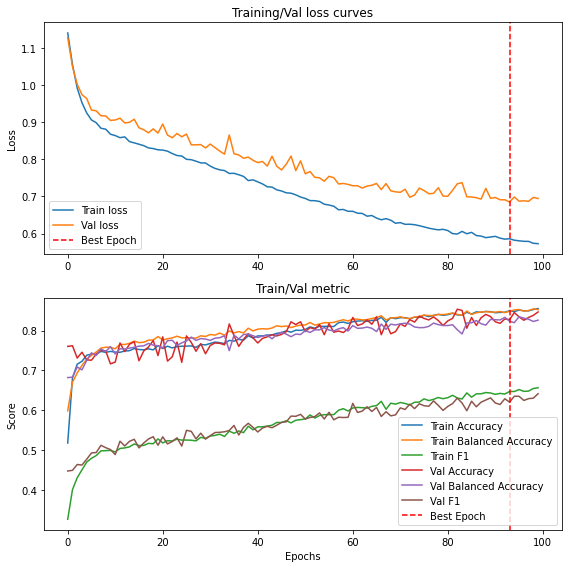

In [33]:
#Training, do not run this again if do not want to train again
from custom_train_val_loop import train_model

#define Loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight_1]).to(device)) #use BCE loss for binary classifcation with class weights
#pos_weight is the ratio of negative to positive

#define optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-4) #use adam

# Set the seed 
set_custom_seed.set_seed(6)

results = train_model(model = model_0,
                      train_dataloader = train_dataloader,
                      val_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      device = device,
                      target_dir = 'trained_model',
                      model_name = 'SimpleCNN_V1',
                      epochs = 100)

Finished training and the model has been saved.

## Load Model for test set evaluation

In [17]:
#instantiate model
loaded_model_0 = SimpleCNN_v1().to(device)

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_0.load_state_dict(torch.load(f = 'trained_model/SimpleCNN_V1_epoch_93.pth')['model_state_dict'])

<All keys matched successfully>

Now we will evaluate performance on the test set with the loaded model and generate metric using custom functions. First, we will create a baseline comparison by prediction only 0, since it is the majority class.

Evaluating model that predict all 0.
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1340
           1       0.00      0.00      0.00       282

    accuracy                           0.83      1622
   macro avg       0.41      0.50      0.45      1622
weighted avg       0.68      0.83      0.75      1622

Confusion Matrix : 
 [[1339    1]
 [ 282    0]]
TN:  1339 FP:  1 FN:  282 TP:  0


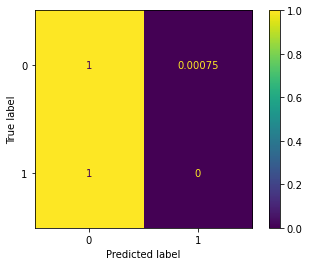

Accuracy: 0.83
Balanced accuracy: 0.50
F1: 0.75


In [18]:
from test_set_evaluation import test_set_prediction, create_report
zero_list = [0] * 1622
zero_list[1621] = 1 #Change the last prediction to 1 so that f1 can be calculated

print('Evaluating model that predict all 0.')
accuracy, balanced_accuracy, f1 = create_report(y_true = data_label_test.iloc[:,1],
              y_pred = zero_list,
              y_pred_prob = None,
              class_map = None)
model_results.append({
    'Model Name': 'Predict 0 all',
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'F1 Score': f1
})

Now we evalaute our performance on the test set.

Evaluating SimpleCNN_V1
Inferencing on cuda.


  0%|          | 0/51 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      benign       0.97      0.85      0.90      1340
   malignant       0.54      0.85      0.66       282

    accuracy                           0.85      1622
   macro avg       0.75      0.85      0.78      1622
weighted avg       0.89      0.85      0.86      1622

Confusion Matrix : 
 [[1137  203]
 [  41  241]]
TN:  1137 FP:  203 FN:  41 TP:  241


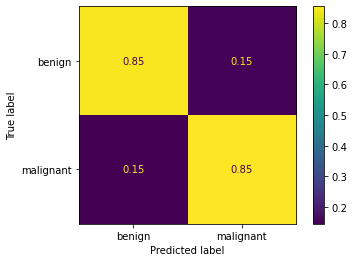

Accuracy: 0.85
Balanced accuracy: 0.85
F1: 0.86


In [19]:
from test_set_evaluation import test_set_prediction, create_report

print('Evaluating SimpleCNN_V1')

# Get true label, predicted label and predicted prob from custom function
y_true_test, y_pred_test, y_pred_prob_test = test_set_prediction(model = loaded_model_0,
                    test_dataloader = test_dataloader) 

#create performance report using custom function and store the metric
accuracy, balanced_accuracy, f1 = create_report(y_true = y_true_test,
              y_pred = y_pred_test,
              y_pred_prob = y_pred_prob_test,
              class_map = label_to_name) 

#Append the metric to the result list
model_results.append({
    'Model Name': 'SimpleCNN_V1_93',
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'F1 Score': f1
})

The performance is pretty good.

# Model 2 - SimpleCNN_V2

Now we will try to improve our model. Since the V1 only utilize 2 Conv2D layer, we will try to increase it to 4 layers. The deeper model might be able to extract more complex feature.

In [30]:
class SimpleCNN_v2(nn.Module):
    def __init__(self):
        super(SimpleCNN_v2, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(64, 64, 3),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1)  # Adjust the input size of the Linear layer based on the output dimensions of conv_block_4
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # x = self.conv_block_2(x)
        # x = self.conv_block_3(x)
        # x = self.conv_block_4(x)
        # x = self.classifier(x)
        #return x
        return self.classifier(self.conv_block_4(self.conv_block_3((self.conv_block_2(self.conv_block_1(x))))))
    
#Instantiate model    
model_0 = SimpleCNN_v2().to(device) 

#See model summary with torchinfo
# do a test pass through of an example input size 
summary(model_0, input_size=[1, 1, 50, 50], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable'])  
    
    

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
SimpleCNN_v2                             --                        [1, 1, 50, 50]            [1, 1]                    --                        --                        True
├─Sequential: 1-1                        --                        [1, 1, 50, 50]            [1, 16, 24, 24]           --                        --                        True
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 50, 50]            [1, 16, 48, 48]           160                       368,640                   True
│    └─ReLU: 2-2                         --                        [1, 16, 48, 48]           [1, 16, 48, 48]           --                        --                        --
│    └─MaxPool2d: 2-3                    2                         [1, 16, 48, 48]           [1, 16, 24, 24]         

The parameter increased a lot, from 8,673 -> 60,481.

## Model Training - Don't Run

Training on cuda.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.12478 | Val loss: 1.06056
Train accuracy: 0.54205 | Train balanced accuracy: 0.63631 | Train F1 score: 0.35559
Validation accuracy: 0.67463 | Validation balanced accuracy: 0.72564 | Validation F1 score: 0.46036
Epoch: 1
-------
Train loss: 0.97098 | Val loss: 0.96130
Train accuracy: 0.68981 | Train balanced accuracy: 0.70654 | Train F1 score: 0.43460
Validation accuracy: 0.74634 | Validation balanced accuracy: 0.71070 | Validation F1 score: 0.47191
Epoch: 2
-------
Train loss: 0.92195 | Val loss: 0.92617
Train accuracy: 0.72762 | Train balanced accuracy: 0.73330 | Train F1 score: 0.46997
Validation accuracy: 0.71318 | Validation balanced accuracy: 0.73658 | Validation F1 score: 0.48189
Epoch: 3
-------
Train loss: 0.89449 | Val loss: 0.91340
Train accuracy: 0.72473 | Train balanced accuracy: 0.74207 | Train F1 score: 0.47595
Validation accuracy: 0.76022 | Validation balanced accuracy: 0.73498 | Validation F1 score: 0.50080
Epoch: 4
-------
Train loss: 0.8

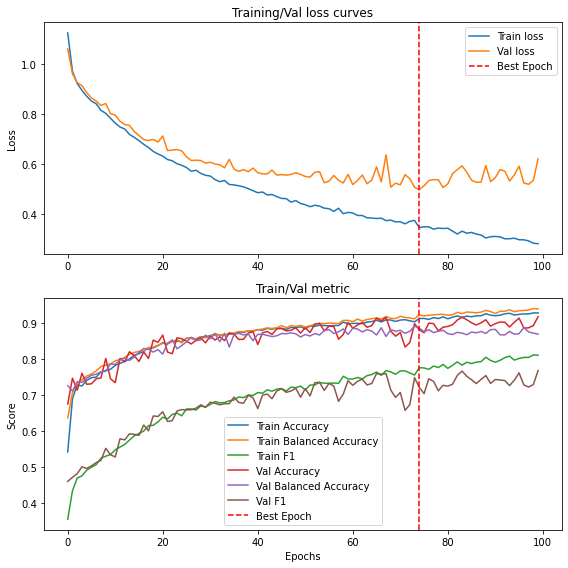

In [31]:
#Training, do not run this again if do not want to train again
from custom_train_val_loop import train_model

#define Loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight_1]).to(device)) #use BCE loss for binary classifcation with class weights
#pos_weight is the ratio of negative to positive

#define optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-4) #use adam

# Set the seed 
set_custom_seed.set_seed(6)

results = train_model(model = model_0,
                      train_dataloader = train_dataloader,
                      val_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      device = device,
                      target_dir = 'trained_model',
                      model_name = 'SimpleCNN_V2',
                      epochs = 100)

## Load Model for test set evaluation

In [40]:
#instantiate model
loaded_model_0 = SimpleCNN_v2().to(device)

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_0.load_state_dict(torch.load(f = 'trained_model/SimpleCNN_V2_epoch_74.pth')['model_state_dict'])

<All keys matched successfully>

Evaluate performance on test set

Evaluating SimpleCNN_V2
Inferencing on cuda.


  0%|          | 0/51 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      benign       0.96      0.94      0.95      1340
   malignant       0.74      0.79      0.76       282

    accuracy                           0.91      1622
   macro avg       0.85      0.87      0.86      1622
weighted avg       0.92      0.91      0.92      1622

Confusion Matrix : 
 [[1260   80]
 [  58  224]]
TN:  1260 FP:  80 FN:  58 TP:  224


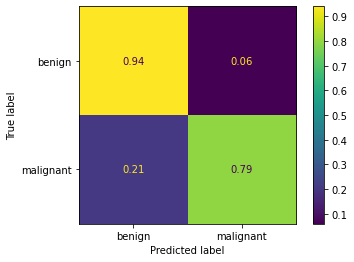

Accuracy: 0.91
Balanced accuracy: 0.87
F1: 0.92


In [41]:
from test_set_evaluation import test_set_prediction, create_report

print('Evaluating SimpleCNN_V2')

# Get true label, predicted label and predicted prob from custom function
y_true_test, y_pred_test, y_pred_prob_test = test_set_prediction(model = loaded_model_0,
                    test_dataloader = test_dataloader) 

#create performance report using custom function and store the metric
accuracy, balanced_accuracy, f1 = create_report(y_true = y_true_test,
              y_pred = y_pred_test,
              y_pred_prob = y_pred_prob_test,
              class_map = label_to_name) 

#Append the metric to the result list
model_results.append({
    'Model Name': 'SimpleCNN_V2_74',
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'F1 Score': f1
})

In [43]:
pd.DataFrame(model_results)

,Model Name,Accuracy,Balanced Accuracy,F1 Score
0,Predict 0 all,0.825524,0.499627,0.747182
1,SimpleCNN_V1_93,0.849568,0.851559,0.861513
2,SimpleCNN_V2_74,0.914920,0.867312,0.916165


It seems that stacking more convolution layers to extract more complex feature does improve our performance.

# Model 3 - SimpleCNN_V3

Now we will introduce batch normalization and dropout layer into our model.
- Batch normalization normalize the output of the previous layer. It reduce covariate shift and helps stabilzie the training process. 
- Dropout layers randomly deactivate certain input neurons with designated probability. It is a regularization technique to prevent overfitting and might allows the model to learn faster and generalize better.

In [45]:
class SimpleCNN_v3(nn.Module):
    def __init__(self):
        super(SimpleCNN_v3, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),  #channel according to output of cnn
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.20) #probability of dropout
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.20),
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.20),
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Dropout(0.20),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 1),
        )

    def forward(self, x: torch.Tensor):
        # x = self.conv_block_1(x)
        # x = self.conv_block_2(x)
        # x = self.conv_block_3(x)
        # x = self.conv_block_4(x)
        # x = self.classifier(x)
        #return x
        return self.classifier(self.conv_block_4(self.conv_block_3((self.conv_block_2(self.conv_block_1(x))))))
    
#Instantiate model    
model_0 = SimpleCNN_v3().to(device) 

#See model summary with torchinfo
# do a test pass through of an example input size 
summary(model_0, input_size=[1, 1, 50, 50], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable'])  
    
    

Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
SimpleCNN_v3                             --                        [1, 1, 50, 50]            [1, 1]                    --                        --                        True
├─Sequential: 1-1                        --                        [1, 1, 50, 50]            [1, 16, 24, 24]           --                        --                        True
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 50, 50]            [1, 16, 48, 48]           160                       368,640                   True
│    └─BatchNorm2d: 2-2                  --                        [1, 16, 48, 48]           [1, 16, 48, 48]           32                        32                        True
│    └─ReLU: 2-3                         --                        [1, 16, 48, 48]           [1, 16, 48, 48]       

## Model Training - Don't Run

Training on cuda.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.05279 | Val loss: 0.97991
Train accuracy: 0.58025 | Train balanced accuracy: 0.65864 | Train F1 score: 0.37543
Validation accuracy: 0.77332 | Validation balanced accuracy: 0.74290 | Validation F1 score: 0.51485
Epoch: 1
-------
Train loss: 0.93027 | Val loss: 0.89260
Train accuracy: 0.70293 | Train balanced accuracy: 0.73153 | Train F1 score: 0.45927
Validation accuracy: 0.73709 | Validation balanced accuracy: 0.75632 | Validation F1 score: 0.50794
Epoch: 2
-------
Train loss: 0.88326 | Val loss: 0.84098
Train accuracy: 0.73187 | Train balanced accuracy: 0.75206 | Train F1 score: 0.48708
Validation accuracy: 0.75405 | Validation balanced accuracy: 0.77717 | Validation F1 score: 0.53294
Epoch: 3
-------
Train loss: 0.85925 | Val loss: 0.80440
Train accuracy: 0.74826 | Train balanced accuracy: 0.75946 | Train F1 score: 0.50096
Validation accuracy: 0.78489 | Validation balanced accuracy: 0.79228 | Validation F1 score: 0.56338
Epoch: 4
-------
Train loss: 0.8

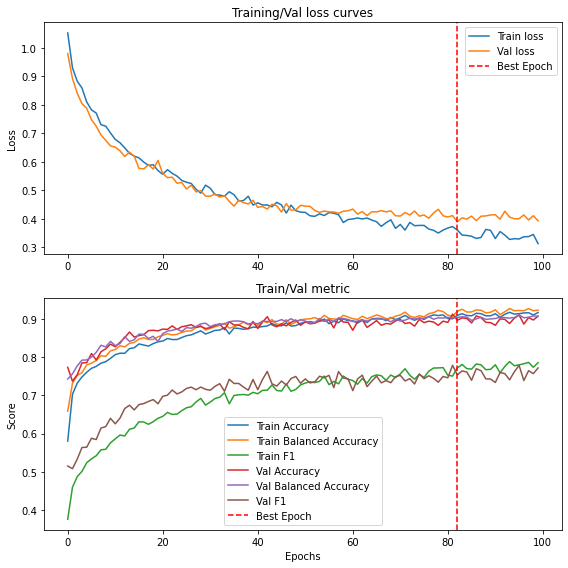

In [46]:
#Training, do not run this again if do not want to train again
from custom_train_val_loop import train_model

#define Loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight_1]).to(device)) #use BCE loss for binary classifcation with class weights
#pos_weight is the ratio of negative to positive

#define optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-4) #use adam

# Set the seed 
set_custom_seed.set_seed(6)

results = train_model(model = model_0,
                      train_dataloader = train_dataloader,
                      val_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      device = device,
                      target_dir = 'trained_model',
                      model_name = 'SimpleCNN_V3',
                      epochs = 100)

## Load Model for test set evaluation

In [47]:
#instantiate model
loaded_model_0 = SimpleCNN_v3().to(device)

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_0.load_state_dict(torch.load(f = 'trained_model/SimpleCNN_V3_epoch_82.pth')['model_state_dict'])

<All keys matched successfully>

Evaluate performance on test set

Evaluating SimpleCNN_V3
Inferencing on cuda.


  0%|          | 0/51 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      benign       0.98      0.92      0.95      1340
   malignant       0.70      0.92      0.79       282

    accuracy                           0.92      1622
   macro avg       0.84      0.92      0.87      1622
weighted avg       0.93      0.92      0.92      1622

Confusion Matrix : 
 [[1229  111]
 [  23  259]]
TN:  1229 FP:  111 FN:  23 TP:  259


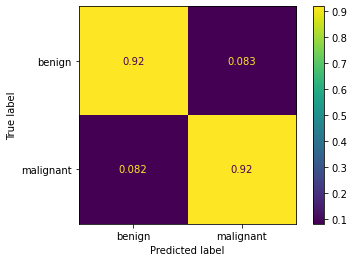

Accuracy: 0.92
Balanced accuracy: 0.92
F1: 0.92


In [48]:
from test_set_evaluation import test_set_prediction, create_report

print('Evaluating SimpleCNN_V3')

# Get true label, predicted label and predicted prob from custom function
y_true_test, y_pred_test, y_pred_prob_test = test_set_prediction(model = loaded_model_0,
                    test_dataloader = test_dataloader) 

#create performance report using custom function and store the metric
accuracy, balanced_accuracy, f1 = create_report(y_true = y_true_test,
              y_pred = y_pred_test,
              y_pred_prob = y_pred_prob_test,
              class_map = label_to_name) 

#Append the metric to the result list
model_results.append({
    'Model Name': 'SimpleCNN_V3_82',
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'F1 Score': f1
})

In [49]:
pd.DataFrame(model_results)

,Model Name,Accuracy,Balanced Accuracy,F1 Score
0,Predict 0 all,0.825524,0.499627,0.747182
1,SimpleCNN_V1_93,0.849568,0.851559,0.861513
2,SimpleCNN_V2_74,0.914920,0.867312,0.916165
3,SimpleCNN_V3_82,0.917386,0.917802,0.921559


Adding batch normalization and dropout does seems to improve our performanc and it only increast the paratemter from 60,481 -> 60,833.

# Model 4 - TinyVGG

This time, I will try to use the same architecture as TinyVGG used in CS231n: Deep Learning for Computer Vision.

## Preparation

In [50]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential( #final classifier block
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*12*12, #this thing determine the input size. There are 2 max pooling layer, so 64/2 =32, 32/2 = 16. If 50, 50/2 = 25. 25 = 12.
                      out_features=output_shape) #set the number of class, in this case there are 3 classes.
        ) #Did not put activation function here as the loss function will be BCE with logit loss. We will pass the raw logit
        # to the loss function and convert to sigmoid later if we want to get the label.
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion. This gets better performance on GPU.

set_custom_seed.set_seed(6)
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=(len(train_data.classes))-1).to(device) #make the number of class equal to classes and minus one, since this is binary
#See model summary with torchinfo
# Install torchinfo if it's not available, import it if it is

from torchinfo import summary
summary(model_0, input_size=[1, 1, 50, 50], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds", 'trainable']) # do a test pass through of an example input size 

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
TinyVGG                                  --                        [1, 1, 50, 50]            [1, 1]                    --                        --                        True
├─Sequential: 1-1                        --                        [1, 1, 50, 50]            [1, 10, 25, 25]           --                        --                        True
│    └─Conv2d: 2-1                       [3, 3]                    [1, 1, 50, 50]            [1, 10, 50, 50]           100                       250,000                   True
│    └─ReLU: 2-2                         --                        [1, 10, 50, 50]           [1, 10, 50, 50]           --                        --                        --
│    └─Conv2d: 2-3                       [3, 3]                    [1, 10, 50, 50]           [1, 10, 50, 50]         

It looks like it does not have batch normalization and dropout layer and as I only specify 10 hidden units, there are less feature map extracted per layer. The parameter is only 4,271 so I expect the performance to be worse.

Testing the model on single data

In [52]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch, path_single = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model. In this case use the first image from test set. 
#the extradimension is batch size. So we unsqueeze to add batch size dimension. In this case, the batch size is 1.

random_number = np.random.randint(0,32)

print(f'Random sample number: {random_number}')
img_single, label_single = img_batch[random_number].unsqueeze(dim=0), label_batch[random_number]
print(f"Single image shape before unsqueeze: {img_batch[random_number].shape}.\nIt is [color_channels, height, width].\n")
print(f"Single image shape: {img_single.shape}.\nIt is [batch_size,color_channels, height, width].\n")

print(f'The image tensor is:{img_single} \n')


# 3. Perform a forward pass on a single image
model_0.eval() #set to eval
with torch.inference_mode(): #set to inference mode
    pred = model_0(img_single.to(device)) #predict the image on GPU
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n") #Print the logit
print(f"Output prediction probabilities:\n{torch.sigmoid(pred)}\n") #Print the probability for each class
print(f"Output prediction label:\n{torch.round(torch.sigmoid(pred))}\n") #Select the maximum probability as predicted label.
print(f"Actual label:\n{label_single}") #Get the actual label.


Random sample number: 9
Single image shape before unsqueeze: torch.Size([1, 50, 50]).
It is [color_channels, height, width].

Single image shape: torch.Size([1, 1, 50, 50]).
It is [batch_size,color_channels, height, width].

The image tensor is:tensor([[[[0.1373, 0.1569, 0.1412,  ..., 0.0627, 0.0588, 0.0706],
          [0.1294, 0.1490, 0.1529,  ..., 0.0627, 0.0627, 0.0745],
          [0.1373, 0.1529, 0.1451,  ..., 0.0667, 0.0667, 0.0784],
          ...,
          [0.3294, 0.2941, 0.1765,  ..., 0.1059, 0.0863, 0.0745],
          [0.6118, 0.5608, 0.4157,  ..., 0.1882, 0.1373, 0.1020],
          [0.7216, 0.6824, 0.5765,  ..., 0.3490, 0.2667, 0.2078]]]]) 

Output logits:
tensor([[-0.0178]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4955]], device='cuda:0')

Output prediction label:
tensor([[0.]], device='cuda:0')

Actual label:
0


The model worked. Proceed to training.

## Model Training - Don't Run

Training on cuda.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------


  1%|          | 1/100 [00:29<48:35, 29.45s/it]

Train loss: 1.15848 | Val loss: 1.17936
Train accuracy: 0.31308 | Train balanced accuracy: 0.54393 | Train F1 score: 0.29583
Validation accuracy: 0.70547 | Validation balanced accuracy: 0.69306 | Validation F1 score: 0.44152
Epoch: 1
-------


  2%|▏         | 2/100 [00:51<40:43, 24.93s/it]

Train loss: 1.09797 | Val loss: 1.07468
Train accuracy: 0.61169 | Train balanced accuracy: 0.66178 | Train F1 score: 0.38195
Validation accuracy: 0.74634 | Validation balanced accuracy: 0.67714 | Validation F1 score: 0.43761
Epoch: 2
-------


  3%|▎         | 3/100 [01:11<37:10, 22.99s/it]

Train loss: 0.99691 | Val loss: 1.01617
Train accuracy: 0.70679 | Train balanced accuracy: 0.68983 | Train F1 score: 0.42468
Validation accuracy: 0.72475 | Validation balanced accuracy: 0.69588 | Validation F1 score: 0.44992
Epoch: 3
-------


  4%|▍         | 4/100 [01:30<34:17, 21.44s/it]

Train loss: 0.95914 | Val loss: 0.98390
Train accuracy: 0.71779 | Train balanced accuracy: 0.70595 | Train F1 score: 0.44267
Validation accuracy: 0.73940 | Validation balanced accuracy: 0.70120 | Validation F1 score: 0.46006
Epoch: 4
-------


  5%|▌         | 5/100 [01:50<33:06, 20.91s/it]

Train loss: 0.93240 | Val loss: 0.97080
Train accuracy: 0.72994 | Train balanced accuracy: 0.72084 | Train F1 score: 0.46029
Validation accuracy: 0.72398 | Validation balanced accuracy: 0.72368 | Validation F1 score: 0.47507
Epoch: 5
-------


  6%|▌         | 6/100 [02:09<31:46, 20.28s/it]

Train loss: 0.90871 | Val loss: 0.93491
Train accuracy: 0.73283 | Train balanced accuracy: 0.72890 | Train F1 score: 0.46874
Validation accuracy: 0.71550 | Validation balanced accuracy: 0.73798 | Validation F1 score: 0.48392
Epoch: 6
-------


  7%|▋         | 7/100 [02:35<33:59, 21.94s/it]

Train loss: 0.89997 | Val loss: 0.92792
Train accuracy: 0.73380 | Train balanced accuracy: 0.74605 | Train F1 score: 0.48315
Validation accuracy: 0.73631 | Validation balanced accuracy: 0.74173 | Validation F1 score: 0.49558
Epoch: 7
-------


  8%|▊         | 8/100 [02:54<32:13, 21.01s/it]

Train loss: 0.87760 | Val loss: 0.91210
Train accuracy: 0.73997 | Train balanced accuracy: 0.75175 | Train F1 score: 0.49094
Validation accuracy: 0.74865 | Validation balanced accuracy: 0.75625 | Validation F1 score: 0.51343
Epoch: 8
-------


  9%|▉         | 9/100 [03:16<32:33, 21.46s/it]

Train loss: 0.87235 | Val loss: 0.90692
Train accuracy: 0.74248 | Train balanced accuracy: 0.75801 | Train F1 score: 0.49718
Validation accuracy: 0.74557 | Validation balanced accuracy: 0.74732 | Validation F1 score: 0.50450
Epoch: 9
-------


 10%|█         | 10/100 [03:34<30:38, 20.43s/it]

Train loss: 0.85682 | Val loss: 0.89277
Train accuracy: 0.74537 | Train balanced accuracy: 0.76107 | Train F1 score: 0.50076
Validation accuracy: 0.71087 | Validation balanced accuracy: 0.74931 | Validation F1 score: 0.49118
Epoch: 10
-------


 11%|█         | 11/100 [03:51<28:23, 19.14s/it]

Train loss: 0.84694 | Val loss: 0.88849
Train accuracy: 0.74730 | Train balanced accuracy: 0.76079 | Train F1 score: 0.50152
Validation accuracy: 0.72860 | Validation balanced accuracy: 0.74767 | Validation F1 score: 0.49714
Epoch: 11
-------


 12%|█▏        | 12/100 [04:09<27:38, 18.84s/it]

Train loss: 0.83510 | Val loss: 0.89202
Train accuracy: 0.74865 | Train balanced accuracy: 0.76924 | Train F1 score: 0.50886
Validation accuracy: 0.77101 | Validation balanced accuracy: 0.75387 | Validation F1 score: 0.52327
Epoch: 12
-------


 13%|█▎        | 13/100 [04:27<26:59, 18.61s/it]

Train loss: 0.83572 | Val loss: 0.87266
Train accuracy: 0.74749 | Train balanced accuracy: 0.76664 | Train F1 score: 0.50622
Validation accuracy: 0.75173 | Validation balanced accuracy: 0.75811 | Validation F1 score: 0.51652
Epoch: 13
-------


 14%|█▍        | 14/100 [04:43<25:47, 17.99s/it]

Train loss: 0.81626 | Val loss: 0.87180
Train accuracy: 0.75058 | Train balanced accuracy: 0.77134 | Train F1 score: 0.51152
Validation accuracy: 0.76947 | Validation balanced accuracy: 0.77060 | Validation F1 score: 0.53643
Epoch: 14
-------


 15%|█▌        | 15/100 [05:02<25:37, 18.09s/it]

Train loss: 0.81017 | Val loss: 0.87459
Train accuracy: 0.75791 | Train balanced accuracy: 0.77858 | Train F1 score: 0.52118
Validation accuracy: 0.77178 | Validation balanced accuracy: 0.76140 | Validation F1 score: 0.53016
Epoch: 15
-------


 16%|█▌        | 16/100 [05:20<25:29, 18.20s/it]

Train loss: 0.80179 | Val loss: 0.84348
Train accuracy: 0.75598 | Train balanced accuracy: 0.77752 | Train F1 score: 0.51956
Validation accuracy: 0.73323 | Validation balanced accuracy: 0.75929 | Validation F1 score: 0.50852
Epoch: 16
-------


 17%|█▋        | 17/100 [05:38<24:51, 17.98s/it]

Train loss: 0.79430 | Val loss: 0.83796
Train accuracy: 0.76235 | Train balanced accuracy: 0.78561 | Train F1 score: 0.52941
Validation accuracy: 0.75019 | Validation balanced accuracy: 0.76248 | Validation F1 score: 0.51929
Epoch: 17
-------


 18%|█▊        | 18/100 [05:57<25:05, 18.35s/it]

Train loss: 0.78823 | Val loss: 0.82397
Train accuracy: 0.75965 | Train balanced accuracy: 0.78248 | Train F1 score: 0.52515
Validation accuracy: 0.76253 | Validation balanced accuracy: 0.77523 | Validation F1 score: 0.53614
Epoch: 18
-------


 19%|█▉        | 19/100 [06:19<26:11, 19.40s/it]

Train loss: 0.77841 | Val loss: 0.83175
Train accuracy: 0.76003 | Train balanced accuracy: 0.78375 | Train F1 score: 0.52664
Validation accuracy: 0.78951 | Validation balanced accuracy: 0.77918 | Validation F1 score: 0.55610
Epoch: 19
-------


 20%|██        | 20/100 [06:35<24:38, 18.49s/it]

Train loss: 0.76995 | Val loss: 0.81760
Train accuracy: 0.76794 | Train balanced accuracy: 0.78879 | Train F1 score: 0.53462
Validation accuracy: 0.75636 | Validation balanced accuracy: 0.78210 | Validation F1 score: 0.53801
Epoch: 20
-------


 21%|██        | 21/100 [06:51<23:22, 17.76s/it]

Train loss: 0.76724 | Val loss: 0.84476
Train accuracy: 0.77064 | Train balanced accuracy: 0.79533 | Train F1 score: 0.54181
Validation accuracy: 0.80648 | Validation balanced accuracy: 0.77707 | Validation F1 score: 0.56649
Epoch: 21
-------


 22%|██▏       | 22/100 [07:08<22:34, 17.37s/it]

Train loss: 0.76281 | Val loss: 0.81054
Train accuracy: 0.77778 | Train balanced accuracy: 0.79435 | Train F1 score: 0.54574
Validation accuracy: 0.73246 | Validation balanced accuracy: 0.78355 | Validation F1 score: 0.52660
Epoch: 22
-------


 23%|██▎       | 23/100 [07:26<22:30, 17.55s/it]

Train loss: 0.75403 | Val loss: 0.79653
Train accuracy: 0.76929 | Train balanced accuracy: 0.79166 | Train F1 score: 0.53822
Validation accuracy: 0.74942 | Validation balanced accuracy: 0.78851 | Validation F1 score: 0.53901
Epoch: 23
-------


 24%|██▍       | 24/100 [07:43<22:19, 17.63s/it]

Train loss: 0.74462 | Val loss: 0.81714
Train accuracy: 0.78221 | Train balanced accuracy: 0.80408 | Train F1 score: 0.55569
Validation accuracy: 0.80493 | Validation balanced accuracy: 0.78144 | Validation F1 score: 0.56899
Epoch: 24
-------


 25%|██▌       | 25/100 [08:00<21:31, 17.21s/it]

Train loss: 0.74549 | Val loss: 0.79395
Train accuracy: 0.77797 | Train balanced accuracy: 0.79486 | Train F1 score: 0.54596
Validation accuracy: 0.75636 | Validation balanced accuracy: 0.79623 | Validation F1 score: 0.54857
Epoch: 25
-------


 26%|██▌       | 26/100 [08:16<20:53, 16.94s/it]

Train loss: 0.73200 | Val loss: 0.79905
Train accuracy: 0.78472 | Train balanced accuracy: 0.80032 | Train F1 score: 0.55467
Validation accuracy: 0.79414 | Validation balanced accuracy: 0.78904 | Validation F1 score: 0.56726
Epoch: 26
-------


 27%|██▋       | 27/100 [08:32<20:18, 16.69s/it]

Train loss: 0.72434 | Val loss: 0.77443
Train accuracy: 0.78607 | Train balanced accuracy: 0.80105 | Train F1 score: 0.55587
Validation accuracy: 0.79568 | Validation balanced accuracy: 0.79350 | Validation F1 score: 0.57189
Epoch: 27
-------


 28%|██▊       | 28/100 [08:48<19:42, 16.43s/it]

Train loss: 0.72342 | Val loss: 0.77307
Train accuracy: 0.78588 | Train balanced accuracy: 0.80252 | Train F1 score: 0.55742
Validation accuracy: 0.78180 | Validation balanced accuracy: 0.79748 | Validation F1 score: 0.56528
Epoch: 28
-------


 29%|██▉       | 29/100 [09:04<19:23, 16.38s/it]

Train loss: 0.71812 | Val loss: 0.77664
Train accuracy: 0.78897 | Train balanced accuracy: 0.80341 | Train F1 score: 0.56029
Validation accuracy: 0.79491 | Validation balanced accuracy: 0.79481 | Validation F1 score: 0.57235
Epoch: 29
-------


 30%|███       | 30/100 [09:22<19:33, 16.77s/it]

Train loss: 0.71261 | Val loss: 0.76730
Train accuracy: 0.79437 | Train balanced accuracy: 0.81038 | Train F1 score: 0.56912
Validation accuracy: 0.77564 | Validation balanced accuracy: 0.79728 | Validation F1 score: 0.56109
Epoch: 30
-------


 31%|███       | 31/100 [09:39<19:35, 17.04s/it]

Train loss: 0.70440 | Val loss: 0.77624
Train accuracy: 0.79630 | Train balanced accuracy: 0.81194 | Train F1 score: 0.57143
Validation accuracy: 0.79337 | Validation balanced accuracy: 0.79211 | Validation F1 score: 0.56913
Epoch: 31
-------


 32%|███▏      | 32/100 [09:59<20:17, 17.91s/it]

Train loss: 0.69764 | Val loss: 0.76656
Train accuracy: 0.79919 | Train balanced accuracy: 0.81381 | Train F1 score: 0.57562
Validation accuracy: 0.79800 | Validation balanced accuracy: 0.78960 | Validation F1 score: 0.57049
Epoch: 32
-------


 33%|███▎      | 33/100 [10:20<21:01, 18.83s/it]

Train loss: 0.69809 | Val loss: 0.75884
Train accuracy: 0.80054 | Train balanced accuracy: 0.81652 | Train F1 score: 0.57865
Validation accuracy: 0.79568 | Validation balanced accuracy: 0.79704 | Validation F1 score: 0.57464
Epoch: 33
-------


 34%|███▍      | 34/100 [10:39<20:38, 18.77s/it]

Train loss: 0.69298 | Val loss: 0.74747
Train accuracy: 0.80150 | Train balanced accuracy: 0.81519 | Train F1 score: 0.57845
Validation accuracy: 0.79645 | Validation balanced accuracy: 0.80457 | Validation F1 score: 0.58095
Epoch: 34
-------


 35%|███▌      | 35/100 [10:55<19:23, 17.90s/it]

Train loss: 0.67905 | Val loss: 0.82195
Train accuracy: 0.80459 | Train balanced accuracy: 0.81751 | Train F1 score: 0.58261
Validation accuracy: 0.84503 | Validation balanced accuracy: 0.77917 | Validation F1 score: 0.60198
Epoch: 35
-------


 36%|███▌      | 36/100 [11:12<18:41, 17.53s/it]

Train loss: 0.67919 | Val loss: 0.75430
Train accuracy: 0.80498 | Train balanced accuracy: 0.81719 | Train F1 score: 0.58240
Validation accuracy: 0.81264 | Validation balanced accuracy: 0.80199 | Validation F1 score: 0.59160
Epoch: 36
-------


 37%|███▋      | 37/100 [11:28<18:01, 17.17s/it]

Train loss: 0.67793 | Val loss: 0.75172
Train accuracy: 0.80903 | Train balanced accuracy: 0.81445 | Train F1 score: 0.58403
Validation accuracy: 0.77101 | Validation balanced accuracy: 0.78742 | Validation F1 score: 0.55068
Epoch: 37
-------


 38%|███▊      | 38/100 [11:44<17:28, 16.92s/it]

Train loss: 0.66804 | Val loss: 0.73724
Train accuracy: 0.81385 | Train balanced accuracy: 0.82440 | Train F1 score: 0.59505
Validation accuracy: 0.79568 | Validation balanced accuracy: 0.79704 | Validation F1 score: 0.57464
Epoch: 38
-------


 39%|███▉      | 39/100 [12:02<17:19, 17.04s/it]

Train loss: 0.65936 | Val loss: 0.74205
Train accuracy: 0.81809 | Train balanced accuracy: 0.82830 | Train F1 score: 0.60127
Validation accuracy: 0.80648 | Validation balanced accuracy: 0.80356 | Validation F1 score: 0.58785
Epoch: 39
-------


 40%|████      | 40/100 [12:18<16:52, 16.87s/it]

Train loss: 0.65980 | Val loss: 0.73436
Train accuracy: 0.81385 | Train balanced accuracy: 0.82481 | Train F1 score: 0.59505
Validation accuracy: 0.80339 | Validation balanced accuracy: 0.80523 | Validation F1 score: 0.58671
Epoch: 40
-------


 41%|████      | 41/100 [12:34<16:27, 16.74s/it]

Train loss: 0.65489 | Val loss: 0.73136
Train accuracy: 0.82137 | Train balanced accuracy: 0.82659 | Train F1 score: 0.60360
Validation accuracy: 0.79414 | Validation balanced accuracy: 0.80317 | Validation F1 score: 0.57820
Epoch: 41
-------


 42%|████▏     | 42/100 [12:50<15:53, 16.43s/it]

Train loss: 0.64632 | Val loss: 0.74587
Train accuracy: 0.82253 | Train balanced accuracy: 0.82992 | Train F1 score: 0.60616
Validation accuracy: 0.80185 | Validation balanced accuracy: 0.79370 | Validation F1 score: 0.57661
Epoch: 42
-------


 43%|████▎     | 43/100 [13:05<15:12, 16.01s/it]

Train loss: 0.64194 | Val loss: 0.72806
Train accuracy: 0.82465 | Train balanced accuracy: 0.83331 | Train F1 score: 0.61137
Validation accuracy: 0.82035 | Validation balanced accuracy: 0.80665 | Validation F1 score: 0.60171
Epoch: 43
-------


 44%|████▍     | 44/100 [13:21<14:59, 16.05s/it]

Train loss: 0.64527 | Val loss: 0.76454
Train accuracy: 0.81925 | Train balanced accuracy: 0.82579 | Train F1 score: 0.60111
Validation accuracy: 0.79877 | Validation balanced accuracy: 0.80597 | Validation F1 score: 0.58373
Epoch: 44
-------


 45%|████▌     | 45/100 [13:36<14:11, 15.49s/it]

Train loss: 0.64261 | Val loss: 0.72726
Train accuracy: 0.82600 | Train balanced accuracy: 0.83269 | Train F1 score: 0.61221
Validation accuracy: 0.80725 | Validation balanced accuracy: 0.79520 | Validation F1 score: 0.58194
Epoch: 45
-------


 46%|████▌     | 46/100 [13:51<13:59, 15.54s/it]

Train loss: 0.63624 | Val loss: 0.71466
Train accuracy: 0.82909 | Train balanced accuracy: 0.83589 | Train F1 score: 0.61711
Validation accuracy: 0.81881 | Validation balanced accuracy: 0.80925 | Validation F1 score: 0.60237
Epoch: 46
-------


 47%|████▋     | 47/100 [14:06<13:34, 15.36s/it]

Train loss: 0.63532 | Val loss: 0.74075
Train accuracy: 0.82735 | Train balanced accuracy: 0.82968 | Train F1 score: 0.61138
Validation accuracy: 0.81110 | Validation balanced accuracy: 0.81166 | Validation F1 score: 0.59770
Epoch: 47
-------


 48%|████▊     | 48/100 [14:21<13:13, 15.25s/it]

Train loss: 0.62955 | Val loss: 0.74140
Train accuracy: 0.82697 | Train balanced accuracy: 0.82993 | Train F1 score: 0.61118
Validation accuracy: 0.83346 | Validation balanced accuracy: 0.79868 | Validation F1 score: 0.60727
Epoch: 48
-------


 49%|████▉     | 49/100 [14:40<13:57, 16.42s/it]

Train loss: 0.63291 | Val loss: 0.73194
Train accuracy: 0.83256 | Train balanced accuracy: 0.83327 | Train F1 score: 0.61896
Validation accuracy: 0.84426 | Validation balanced accuracy: 0.81226 | Validation F1 score: 0.62868
Epoch: 49
-------


 50%|█████     | 50/100 [14:58<14:04, 16.88s/it]

Train loss: 0.62622 | Val loss: 0.76856
Train accuracy: 0.83372 | Train balanced accuracy: 0.83539 | Train F1 score: 0.62160
Validation accuracy: 0.83886 | Validation balanced accuracy: 0.79487 | Validation F1 score: 0.60935
Epoch: 50
-------


 51%|█████     | 51/100 [15:17<14:09, 17.34s/it]

Train loss: 0.62513 | Val loss: 0.70861
Train accuracy: 0.83526 | Train balanced accuracy: 0.83910 | Train F1 score: 0.62544
Validation accuracy: 0.81419 | Validation balanced accuracy: 0.81882 | Validation F1 score: 0.60556
Epoch: 51
-------


 52%|█████▏    | 52/100 [15:31<13:07, 16.40s/it]

Train loss: 0.62395 | Val loss: 0.74488
Train accuracy: 0.82909 | Train balanced accuracy: 0.83691 | Train F1 score: 0.61810
Validation accuracy: 0.83115 | Validation balanced accuracy: 0.79551 | Validation F1 score: 0.60254
Epoch: 52
-------


 53%|█████▎    | 53/100 [15:47<12:40, 16.18s/it]

Train loss: 0.62493 | Val loss: 0.70564
Train accuracy: 0.83333 | Train balanced accuracy: 0.83747 | Train F1 score: 0.62238
Validation accuracy: 0.81958 | Validation balanced accuracy: 0.81678 | Validation F1 score: 0.60870
Epoch: 53
-------


 54%|█████▍    | 54/100 [16:04<12:36, 16.44s/it]

Train loss: 0.61712 | Val loss: 0.72536
Train accuracy: 0.83256 | Train balanced accuracy: 0.83613 | Train F1 score: 0.62096
Validation accuracy: 0.84194 | Validation balanced accuracy: 0.80910 | Validation F1 score: 0.62385
Epoch: 54
-------


 55%|█████▌    | 55/100 [16:18<11:51, 15.81s/it]

Train loss: 0.61755 | Val loss: 0.71434
Train accuracy: 0.83295 | Train balanced accuracy: 0.83445 | Train F1 score: 0.62018
Validation accuracy: 0.78720 | Validation balanced accuracy: 0.80074 | Validation F1 score: 0.57143
Epoch: 55
-------


 56%|█████▌    | 56/100 [16:35<11:55, 16.25s/it]

Train loss: 0.60835 | Val loss: 0.70689
Train accuracy: 0.83912 | Train balanced accuracy: 0.84338 | Train F1 score: 0.63260
Validation accuracy: 0.82729 | Validation balanced accuracy: 0.80555 | Validation F1 score: 0.60702
Epoch: 56
-------


 57%|█████▋    | 57/100 [16:57<12:53, 17.99s/it]

Train loss: 0.60643 | Val loss: 0.70904
Train accuracy: 0.83526 | Train balanced accuracy: 0.83869 | Train F1 score: 0.62544
Validation accuracy: 0.80416 | Validation balanced accuracy: 0.80570 | Validation F1 score: 0.58766
Epoch: 57
-------


 58%|█████▊    | 58/100 [17:13<12:10, 17.40s/it]

Train loss: 0.60577 | Val loss: 0.68089
Train accuracy: 0.83931 | Train balanced accuracy: 0.83913 | Train F1 score: 0.62961
Validation accuracy: 0.81342 | Validation balanced accuracy: 0.82365 | Validation F1 score: 0.60841
Epoch: 58
-------


 59%|█████▉    | 59/100 [17:27<11:13, 16.42s/it]

Train loss: 0.60748 | Val loss: 0.68867
Train accuracy: 0.83816 | Train balanced accuracy: 0.83899 | Train F1 score: 0.62860
Validation accuracy: 0.80108 | Validation balanced accuracy: 0.82503 | Validation F1 score: 0.59938
Epoch: 59
-------


 60%|██████    | 60/100 [17:43<10:45, 16.14s/it]

Train loss: 0.60612 | Val loss: 0.69066
Train accuracy: 0.83796 | Train balanced accuracy: 0.84357 | Train F1 score: 0.63126
Validation accuracy: 0.81958 | Validation balanced accuracy: 0.82561 | Validation F1 score: 0.61513
Epoch: 60
-------


 61%|██████    | 61/100 [17:57<10:10, 15.65s/it]

Train loss: 0.60097 | Val loss: 0.68439
Train accuracy: 0.84510 | Train balanced accuracy: 0.84791 | Train F1 score: 0.64200
Validation accuracy: 0.84503 | Validation balanced accuracy: 0.82686 | Validation F1 score: 0.64043
Epoch: 61
-------


 62%|██████▏   | 62/100 [18:12<09:39, 15.25s/it]

Train loss: 0.59222 | Val loss: 0.69566
Train accuracy: 0.84144 | Train balanced accuracy: 0.84381 | Train F1 score: 0.63531
Validation accuracy: 0.82652 | Validation balanced accuracy: 0.81568 | Validation F1 score: 0.61407
Epoch: 62
-------


 63%|██████▎   | 63/100 [18:26<09:12, 14.94s/it]

Train loss: 0.59291 | Val loss: 0.69786
Train accuracy: 0.84336 | Train balanced accuracy: 0.84639 | Train F1 score: 0.63911
Validation accuracy: 0.83192 | Validation balanced accuracy: 0.82247 | Validation F1 score: 0.62414
Epoch: 63
-------


 64%|██████▍   | 64/100 [18:40<08:51, 14.77s/it]

Train loss: 0.58900 | Val loss: 0.70462
Train accuracy: 0.84221 | Train balanced accuracy: 0.84611 | Train F1 score: 0.63741
Validation accuracy: 0.83269 | Validation balanced accuracy: 0.81411 | Validation F1 score: 0.61863
Epoch: 64
-------


 65%|██████▌   | 65/100 [18:55<08:31, 14.62s/it]

Train loss: 0.59451 | Val loss: 0.69752
Train accuracy: 0.84587 | Train balanced accuracy: 0.84646 | Train F1 score: 0.64186
Validation accuracy: 0.82498 | Validation balanced accuracy: 0.82004 | Validation F1 score: 0.61591
Epoch: 65
-------


 66%|██████▌   | 66/100 [19:12<08:46, 15.49s/it]

Train loss: 0.59041 | Val loss: 0.70202
Train accuracy: 0.84066 | Train balanced accuracy: 0.84614 | Train F1 score: 0.63580
Validation accuracy: 0.85428 | Validation balanced accuracy: 0.82009 | Validation F1 score: 0.64540
Epoch: 66
-------


 67%|██████▋   | 67/100 [19:35<09:44, 17.70s/it]

Train loss: 0.58145 | Val loss: 0.67730
Train accuracy: 0.84645 | Train balanced accuracy: 0.84435 | Train F1 score: 0.64079
Validation accuracy: 0.81804 | Validation balanced accuracy: 0.83351 | Validation F1 score: 0.61935
Epoch: 67
-------


 68%|██████▊   | 68/100 [19:51<09:05, 17.06s/it]

Train loss: 0.58616 | Val loss: 0.72177
Train accuracy: 0.84375 | Train balanced accuracy: 0.84948 | Train F1 score: 0.64159
Validation accuracy: 0.82652 | Validation balanced accuracy: 0.81038 | Validation F1 score: 0.61005
Epoch: 68
-------


 69%|██████▉   | 69/100 [20:07<08:42, 16.85s/it]

Train loss: 0.59082 | Val loss: 0.68975
Train accuracy: 0.84838 | Train balanced accuracy: 0.84653 | Train F1 score: 0.64467
Validation accuracy: 0.80108 | Validation balanced accuracy: 0.82326 | Validation F1 score: 0.59813
Epoch: 69
-------


 70%|███████   | 70/100 [20:27<08:52, 17.76s/it]

Train loss: 0.57975 | Val loss: 0.68598
Train accuracy: 0.84529 | Train balanced accuracy: 0.84659 | Train F1 score: 0.64132
Validation accuracy: 0.79568 | Validation balanced accuracy: 0.82000 | Validation F1 score: 0.59168
Epoch: 70
-------


 71%|███████   | 71/100 [20:45<08:37, 17.84s/it]

Train loss: 0.57720 | Val loss: 0.68865
Train accuracy: 0.84587 | Train balanced accuracy: 0.84884 | Train F1 score: 0.64346
Validation accuracy: 0.81264 | Validation balanced accuracy: 0.82495 | Validation F1 score: 0.60870
Epoch: 71
-------


 72%|███████▏  | 72/100 [21:00<08:00, 17.17s/it]

Train loss: 0.57503 | Val loss: 0.70020
Train accuracy: 0.85204 | Train balanced accuracy: 0.85437 | Train F1 score: 0.65372
Validation accuracy: 0.80879 | Validation balanced accuracy: 0.82085 | Validation F1 score: 0.60256
Epoch: 72
-------


 73%|███████▎  | 73/100 [21:16<07:30, 16.67s/it]

Train loss: 0.57995 | Val loss: 0.65895
Train accuracy: 0.84896 | Train balanced accuracy: 0.84966 | Train F1 score: 0.64714
Validation accuracy: 0.83423 | Validation balanced accuracy: 0.82917 | Validation F1 score: 0.63122
Epoch: 73
-------


 74%|███████▍  | 74/100 [21:34<07:26, 17.17s/it]

Train loss: 0.57702 | Val loss: 0.67583
Train accuracy: 0.84780 | Train balanced accuracy: 0.84897 | Train F1 score: 0.64539
Validation accuracy: 0.82498 | Validation balanced accuracy: 0.81121 | Validation F1 score: 0.60929
Epoch: 74
-------


 75%|███████▌  | 75/100 [21:52<07:12, 17.29s/it]

Train loss: 0.57199 | Val loss: 0.68934
Train accuracy: 0.84973 | Train balanced accuracy: 0.85156 | Train F1 score: 0.64926
Validation accuracy: 0.83423 | Validation balanced accuracy: 0.81680 | Validation F1 score: 0.62214
Epoch: 75
-------


 76%|███████▌  | 76/100 [22:08<06:45, 16.90s/it]

Train loss: 0.57668 | Val loss: 0.69369
Train accuracy: 0.84973 | Train balanced accuracy: 0.84781 | Train F1 score: 0.64703
Validation accuracy: 0.83192 | Validation balanced accuracy: 0.82070 | Validation F1 score: 0.62284
Epoch: 76
-------


 77%|███████▋  | 77/100 [22:23<06:18, 16.44s/it]

Train loss: 0.57749 | Val loss: 0.68102
Train accuracy: 0.84433 | Train balanced accuracy: 0.84411 | Train F1 score: 0.63860
Validation accuracy: 0.83577 | Validation balanced accuracy: 0.82127 | Validation F1 score: 0.62697
Epoch: 77
-------


 78%|███████▊  | 78/100 [22:41<06:11, 16.90s/it]

Train loss: 0.56840 | Val loss: 0.67480
Train accuracy: 0.85089 | Train balanced accuracy: 0.84993 | Train F1 score: 0.64975
Validation accuracy: 0.83577 | Validation balanced accuracy: 0.82833 | Validation F1 score: 0.63212
Epoch: 78
-------


 79%|███████▉  | 79/100 [22:57<05:47, 16.57s/it]

Train loss: 0.56700 | Val loss: 0.70656
Train accuracy: 0.85127 | Train balanced accuracy: 0.85350 | Train F1 score: 0.65255
Validation accuracy: 0.81573 | Validation balanced accuracy: 0.82152 | Validation F1 score: 0.60884
Epoch: 79
-------


 80%|████████  | 80/100 [23:12<05:19, 15.97s/it]

Train loss: 0.56619 | Val loss: 0.67294
Train accuracy: 0.85108 | Train balanced accuracy: 0.85332 | Train F1 score: 0.65194
Validation accuracy: 0.82113 | Validation balanced accuracy: 0.81948 | Validation F1 score: 0.61204
Epoch: 80
-------


 81%|████████  | 81/100 [23:26<04:55, 15.53s/it]

Train loss: 0.56731 | Val loss: 0.67136
Train accuracy: 0.85359 | Train balanced accuracy: 0.85386 | Train F1 score: 0.65516
Validation accuracy: 0.82884 | Validation balanced accuracy: 0.82237 | Validation F1 score: 0.62116
Epoch: 81
-------


 82%|████████▏ | 82/100 [23:43<04:49, 16.06s/it]

Train loss: 0.56070 | Val loss: 0.69882
Train accuracy: 0.85147 | Train balanced accuracy: 0.85552 | Train F1 score: 0.65409
Validation accuracy: 0.83038 | Validation balanced accuracy: 0.82330 | Validation F1 score: 0.62329
Epoch: 82
-------


 83%|████████▎ | 83/100 [24:00<04:38, 16.39s/it]

Train loss: 0.56391 | Val loss: 0.71912
Train accuracy: 0.84954 | Train balanced accuracy: 0.85342 | Train F1 score: 0.65054
Validation accuracy: 0.86662 | Validation balanced accuracy: 0.82048 | Validation F1 score: 0.66012
Epoch: 83
-------


 84%|████████▍ | 84/100 [24:20<04:37, 17.32s/it]

Train loss: 0.56780 | Val loss: 0.73806
Train accuracy: 0.85050 | Train balanced accuracy: 0.85542 | Train F1 score: 0.65293
Validation accuracy: 0.87587 | Validation balanced accuracy: 0.81018 | Validation F1 score: 0.66388
Epoch: 84
-------


 85%|████████▌ | 85/100 [24:36<04:11, 16.80s/it]

Train loss: 0.56482 | Val loss: 0.66010
Train accuracy: 0.85262 | Train balanced accuracy: 0.85097 | Train F1 score: 0.65241
Validation accuracy: 0.82344 | Validation balanced accuracy: 0.82971 | Validation F1 score: 0.62149
Epoch: 85
-------


 86%|████████▌ | 86/100 [24:50<03:44, 16.04s/it]

Train loss: 0.56554 | Val loss: 0.67120
Train accuracy: 0.85127 | Train balanced accuracy: 0.85207 | Train F1 score: 0.65160
Validation accuracy: 0.82961 | Validation balanced accuracy: 0.82461 | Validation F1 score: 0.62351
Epoch: 86
-------


 87%|████████▋ | 87/100 [25:08<03:38, 16.79s/it]

Train loss: 0.55818 | Val loss: 0.67478
Train accuracy: 0.85764 | Train balanced accuracy: 0.86195 | Train F1 score: 0.66485
Validation accuracy: 0.81573 | Validation balanced accuracy: 0.82858 | Validation F1 score: 0.61389
Epoch: 87
-------


 88%|████████▊ | 88/100 [25:24<03:16, 16.35s/it]

Train loss: 0.55525 | Val loss: 0.67157
Train accuracy: 0.85706 | Train balanced accuracy: 0.85593 | Train F1 score: 0.66056
Validation accuracy: 0.84888 | Validation balanced accuracy: 0.82919 | Validation F1 score: 0.64621
Epoch: 88
-------


 89%|████████▉ | 89/100 [25:41<03:04, 16.78s/it]

Train loss: 0.55169 | Val loss: 0.68596
Train accuracy: 0.85725 | Train balanced accuracy: 0.85748 | Train F1 score: 0.66179
Validation accuracy: 0.85197 | Validation balanced accuracy: 0.82752 | Validation F1 score: 0.64835
Epoch: 89
-------


 90%|█████████ | 90/100 [25:58<02:45, 16.57s/it]

Train loss: 0.54908 | Val loss: 0.66086
Train accuracy: 0.85918 | Train balanced accuracy: 0.85965 | Train F1 score: 0.66575
Validation accuracy: 0.82652 | Validation balanced accuracy: 0.83510 | Validation F1 score: 0.62810
Epoch: 90
-------


 91%|█████████ | 91/100 [26:13<02:27, 16.35s/it]

Train loss: 0.55921 | Val loss: 0.67459
Train accuracy: 0.85571 | Train balanced accuracy: 0.85895 | Train F1 score: 0.66092
Validation accuracy: 0.83346 | Validation balanced accuracy: 0.84106 | Validation F1 score: 0.63880
Epoch: 91
-------


 92%|█████████▏| 92/100 [26:29<02:08, 16.01s/it]

Train loss: 0.55230 | Val loss: 0.66035
Train accuracy: 0.85667 | Train balanced accuracy: 0.86149 | Train F1 score: 0.66395
Validation accuracy: 0.82806 | Validation balanced accuracy: 0.83074 | Validation F1 score: 0.62647
Epoch: 92
-------


 93%|█████████▎| 93/100 [26:47<01:57, 16.76s/it]

Train loss: 0.54747 | Val loss: 0.66961
Train accuracy: 0.85918 | Train balanced accuracy: 0.86108 | Train F1 score: 0.66667
Validation accuracy: 0.82267 | Validation balanced accuracy: 0.82924 | Validation F1 score: 0.62046
Epoch: 93
-------


 94%|█████████▍| 94/100 [27:02<01:36, 16.09s/it]

Train loss: 0.55234 | Val loss: 0.65579
Train accuracy: 0.85571 | Train balanced accuracy: 0.85901 | Train F1 score: 0.66123
Validation accuracy: 0.84657 | Validation balanced accuracy: 0.83839 | Validation F1 score: 0.65026
Epoch: 94
-------


 95%|█████████▌| 95/100 [27:20<01:23, 16.75s/it]

Train loss: 0.54788 | Val loss: 0.67105
Train accuracy: 0.85610 | Train balanced accuracy: 0.86162 | Train F1 score: 0.66336
Validation accuracy: 0.85274 | Validation balanced accuracy: 0.83329 | Validation F1 score: 0.65336
Epoch: 95
-------


 96%|█████████▌| 96/100 [27:36<01:06, 16.63s/it]

Train loss: 0.54979 | Val loss: 0.66919
Train accuracy: 0.85494 | Train balanced accuracy: 0.86141 | Train F1 score: 0.66187
Validation accuracy: 0.84503 | Validation balanced accuracy: 0.83569 | Validation F1 score: 0.64675
Epoch: 96
-------


 97%|█████████▋| 97/100 [27:54<00:51, 17.04s/it]

Train loss: 0.54704 | Val loss: 0.66471
Train accuracy: 0.86034 | Train balanced accuracy: 0.85749 | Train F1 score: 0.66574
Validation accuracy: 0.82344 | Validation balanced accuracy: 0.83501 | Validation F1 score: 0.62520
Epoch: 97
-------


 98%|█████████▊| 98/100 [28:15<00:36, 18.06s/it]

Train loss: 0.54359 | Val loss: 0.66186
Train accuracy: 0.85860 | Train balanced accuracy: 0.86264 | Train F1 score: 0.66697
Validation accuracy: 0.83346 | Validation balanced accuracy: 0.83400 | Validation F1 score: 0.63390
Epoch: 98
-------


 99%|█████████▉| 99/100 [28:34<00:18, 18.52s/it]

Train loss: 0.54353 | Val loss: 0.69123
Train accuracy: 0.85976 | Train balanced accuracy: 0.86238 | Train F1 score: 0.66819
Validation accuracy: 0.83963 | Validation balanced accuracy: 0.83066 | Validation F1 score: 0.63763
Epoch: 99
-------


100%|██████████| 100/100 [28:53<00:00, 17.33s/it]

Train loss: 0.53969 | Val loss: 0.66602
Train accuracy: 0.86265 | Train balanced accuracy: 0.86030 | Train F1 score: 0.67037
Validation accuracy: 0.85428 | Validation balanced accuracy: 0.83422 | Validation F1 score: 0.65574
The best model is at epoch 93
Saving model state_dict, optimizer, best_val_loss, epoch
Saving...: trained_model\TinyVgg_epoch_93.pth


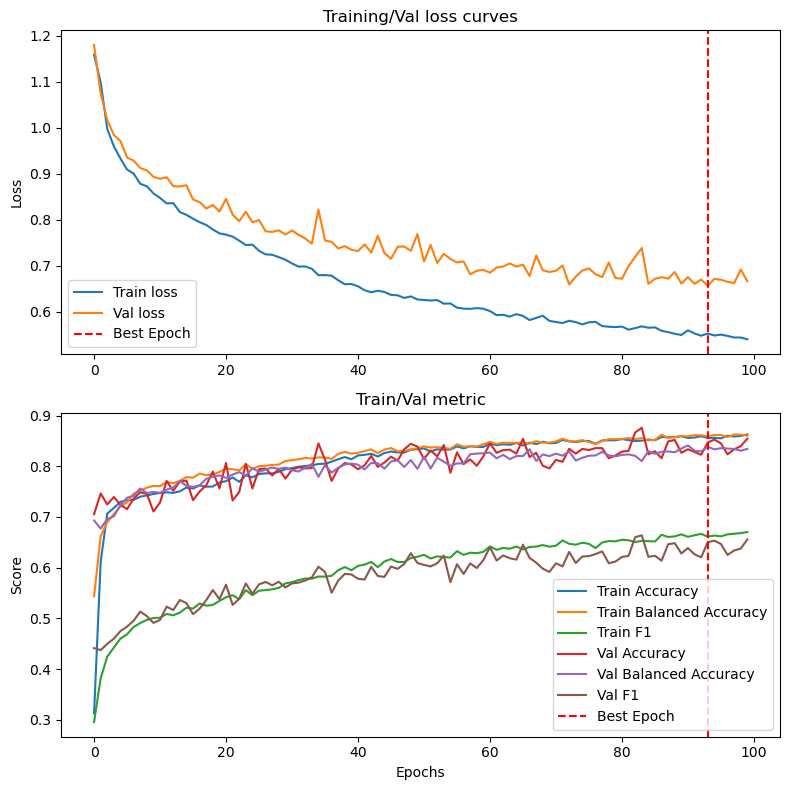

In [19]:
#Training, do not run this again if do not want to train again
from custom_train_val_loop import train_model

#define Loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight_1]).to(device)) #use BCE loss for binary classifcation with class weights
#pos_weight is the ratio of negative to positive

#define optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-4) #use adam

# Set the seed 
set_custom_seed.set_seed(6)

results = train_model(model = model_0,
                      train_dataloader = train_dataloader,
                      val_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      device = device,
                      target_dir = 'trained_model',
                      model_name = 'TinyVgg',
                      epochs = 100)

The training has finished and the model has been saved.

## Load Model for test set evaluation

In [53]:
loaded_model_0 = TinyVGG(input_shape=1, 
                  hidden_units=10, 
                  output_shape=(len(train_data.classes))-1).to(device) 

#since I saved many keys in the pth file, I need to specify that I want to load model_state_dict.
loaded_model_0.load_state_dict(torch.load(f = 'trained_model/TinyVgg_epoch_93.pth')['model_state_dict'])


<All keys matched successfully>

Now we will evaluate performance on the test set with the loaded model and generate metric using custom functions

Evaluating TinyVgg_V1
Inferencing on cuda.


  0%|          | 0/51 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      benign       0.96      0.86      0.91      1340
   malignant       0.56      0.84      0.67       282

    accuracy                           0.86      1622
   macro avg       0.76      0.85      0.79      1622
weighted avg       0.89      0.86      0.87      1622

Confusion Matrix : 
 [[1153  187]
 [  45  237]]
TN:  1153 FP:  187 FN:  45 TP:  237


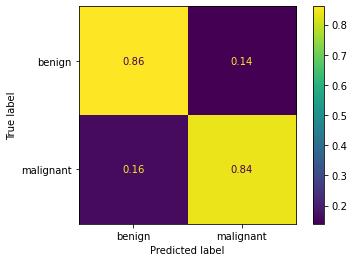

Accuracy: 0.86
Balanced accuracy: 0.85
F1: 0.87


In [55]:
from test_set_evaluation import test_set_prediction, create_report

print('Evaluating TinyVgg_V1')

# Get true label, predicted label and predicted prob from custom function
y_true_test, y_pred_test, y_pred_prob_test = test_set_prediction(model = loaded_model_0,
                    test_dataloader = test_dataloader) 

#create performance report using custom function and store the metric
accuracy, balanced_accuracy, f1 = create_report(y_true = y_true_test,
              y_pred = y_pred_test,
              y_pred_prob = y_pred_prob_test,
              class_map = label_to_name) 

#Append the metric to the result list
model_results.append({
    'Model Name': 'TinyVgg_V1_93',
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'F1 Score': f1
})

In [56]:
#See all results
pd.DataFrame(model_results)

,Model Name,Accuracy,Balanced Accuracy,F1 Score
0,Predict 0 all,0.825524,0.499627,0.747182
1,SimpleCNN_V1_93,0.849568,0.851559,0.861513
2,SimpleCNN_V2_74,0.914920,0.867312,0.916165
3,SimpleCNN_V3_82,0.917386,0.917802,0.921559
4,TinyVgg_V1_93,0.856967,0.850437,0.867350


Indeed, it performed worse than my SimpleCNN_V3. Still, with around only 1/10 parameter, the performance does not seems to decrease that much. Also, it performs better then SimpleCNN_V1 while having less parameters, suggesting that deeper is better than shallow model even with less parameters.

# Transfer Learning - EfficientNet

Now I will harness the power of pretrained model.

## Preparation

In [57]:
# Setup the model with pretrained weights and send it to the target device 
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights. 
# In this case, is equivalent to EfficientNet_B0_Weights.IMAGENET1K_V
model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device) #Get the model using the weights we load.

#Use torch summery to see model summery
summary(model=model_0, 
        input_size=(1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\Nut19\anaconda3\envs\ml_research\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [58]:
# # Code for freezing all base layers in the "features" section of the model (the feature extractor, it is the Sequantial (features) section in the model summery) by setting requires_grad=False
# for param in model_0.features.parameters(): #loop through parameter of the features section
#                                         # and set requries grad to true to unfrozen the features layer 
#     param.requires_grad = False


# Recreate the classifier layer to output 1 logit and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

#Use torch summery to see model summery
summary(model=model_0, 
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"image.png
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

4,008,829 parameters! That's lot more than SimpleCNN_V3. Let's see how it will hold up. We will try fine-tuning by training on all layer since we have a lot of data.

In [59]:
# Define transform

#Since efficient net takes [3,244,244] but out image is [1,50,50], we need to expand our thrid dimension by repeat
def grayscale_to_rgb(image):
    return image.repeat(3, 1, 1)

train_transforms = transforms.Compose([ #compose is used to compile all transform step
    # Resize the images
    transforms.Resize((224, 224)),    
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance

    transforms.ToTensor(), # use ToTensor() last to get everything between 0 & 1
    transforms.Lambda(grayscale_to_rgb) #makes the thid dimension 3, so now the size is [3,244,244]
])

# Don't need to perform augmentation on the val, test data
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Lambda(grayscale_to_rgb)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Lambda(grayscale_to_rgb)
])



In [60]:
#Craete Dataloader again with this transform
train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, class_labels = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               val_dir = val_dir,                
                                                                               test_dir=test_dir,
                                                                               train_transform=train_transforms, 
                                                                               val_transform=val_transforms, 
                                                                               test_transform=test_transforms, 
                                                                               train_label_df = data_label_train,
                                                                               val_label_df = data_label_val,
                                                                               test_label_df = data_label_test,
                                                                               class_map = label_to_name,                
                                                                              batch_size=32) # set mini-batch size to 32

train_dataloader, val_dataloader, test_dataloader, class_labels

(<torch.utils.data.dataloader.DataLoader at 0x22f03892160>,
 [0, 1])

Number of batches in train set:162
Number of batches in val set:41
Number of batches in test set:51
Class labels: [0, 1]

Getting random image from train data at index 227


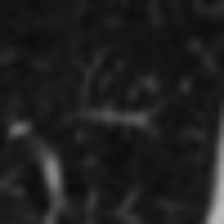

Dimension of an image tensor: torch.Size([3, 224, 224])
Label of data: 0
Tensor of data: tensor([[[0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         [0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         [0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         ...,
         [0.7059, 0.7059, 0.7059,  ..., 0.1059, 0.1059, 0.1059],
         [0.7059, 0.7059, 0.7059,  ..., 0.1059, 0.1059, 0.1059],
         [0.7059, 0.7059, 0.7059,  ..., 0.1059, 0.1059, 0.1059]],

        [[0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         [0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         [0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         ...,
         [0.7059, 0.7059, 0.7059,  ..., 0.1059, 0.1059, 0.1059],
         [0.7059, 0.7059, 0.7059,  ..., 0.1059, 0.1059, 0.1059],
         [0.7059, 0.7059, 0.7059,  ..., 0.1059, 0.1059, 0.1059]],

        [[0.1412, 0.1412, 0.1412,  ..., 0.0745, 0.0745, 0.0745],
         [0.1412, 0.1412, 0.1412, 

In [61]:
#Count the number of batch, see iamge after transform
print(f'Number of batches in train set:{len(train_dataloader)}')
print(f'Number of batches in val set:{len(val_dataloader)}')
print(f'Number of batches in test set:{len(test_dataloader)}')
print(f'Class labels: {class_labels}')

#Getting a random sample from the training set
random_number = np.random.randint(0,len(train_data))
print(f'\nGetting random image from train data at index {random_number}')
single_image = train_data[random_number][0]
single_image_toPil = transforms.ToPILImage() 
img =  single_image_toPil(single_image)  
display(img)
print(f'Dimension of an image tensor: {train_data[random_number][0].size()}')
print(f'Label of data: {train_data[random_number][1]}')
print(f'Tensor of data: {train_data[random_number][0]}')
print(f'Path of data: {train_data[random_number][2]}')
print(f'Data type: {train_data[random_number][0].dtype}')

## Model Training - Don't run

Training on cuda.


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.81614 | Val loss: 0.51241
Train accuracy: 0.75714 | Train balanced accuracy: 0.76572 | Train F1 score: 0.51069
Validation accuracy: 0.84194 | Validation balanced accuracy: 0.87621 | Validation F1 score: 0.66989
Epoch: 1
-------
Train loss: 0.36740 | Val loss: 0.35730
Train accuracy: 0.92284 | Train balanced accuracy: 0.92436 | Train F1 score: 0.79654
Validation accuracy: 0.93832 | Validation balanced accuracy: 0.92563 | Validation F1 score: 0.83539
Epoch: 2
-------
Train loss: 0.22757 | Val loss: 0.35024
Train accuracy: 0.95332 | Train balanced accuracy: 0.95542 | Train F1 score: 0.86989
Validation accuracy: 0.94140 | Validation balanced accuracy: 0.93103 | Validation F1 score: 0.84362
Epoch: 3
-------
Train loss: 0.16590 | Val loss: 0.32019
Train accuracy: 0.96701 | Train balanced accuracy: 0.96789 | Train F1 score: 0.90537
Validation accuracy: 0.94526 | Validation balanced accuracy: 0.93512 | Validation F1 score: 0.85300
Epoch: 4
-------
Train loss: 0.1

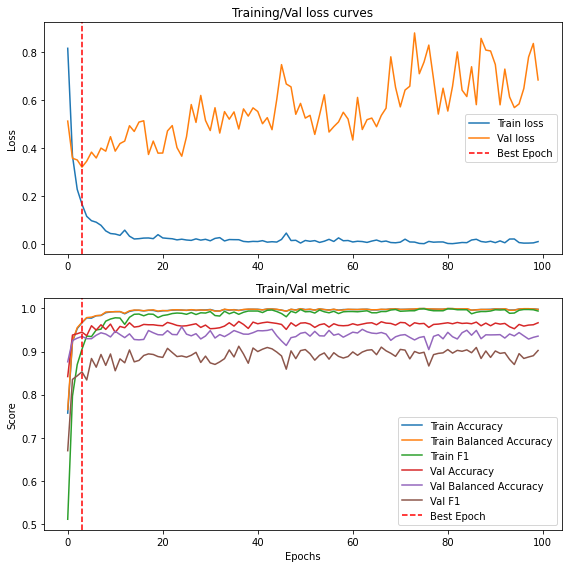

In [29]:
#Training, do not run this again if do not want to train again
from custom_train_val_loop import train_model

#define Loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([weight_1]).to(device)) 

#define optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 1e-4) 

# Set the seed 
set_custom_seed.set_seed(6)

results = train_model(model = model_0,
                      train_dataloader = train_dataloader,
                      val_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      device = device,
                      target_dir = 'trained_model',
                      model_name = 'EfficientNet_B0_finetune',
                      epochs = 100)

The training has finished and the model has been saved. It seems that it start to overfit on very few epoches (epoch 3).

## Load Model for test set evaluation

In [62]:
loaded_model_0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
loaded_model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True)).to(device)

loaded_model_0.load_state_dict(torch.load(f = 'trained_model/EfficientNet_B0_finetune_epoch_3.pth')['model_state_dict'])

<All keys matched successfully>

Evaluating EfficientNet_B0_Finetune
Inferencing on cuda.


  0%|          | 0/51 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      benign       0.98      0.99      0.98      1340
   malignant       0.93      0.89      0.91       282

    accuracy                           0.97      1622
   macro avg       0.95      0.94      0.95      1622
weighted avg       0.97      0.97      0.97      1622

Confusion Matrix : 
 [[1320   20]
 [  30  252]]
TN:  1320 FP:  20 FN:  30 TP:  252


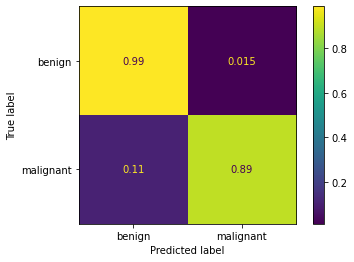

Accuracy: 0.97
Balanced accuracy: 0.94
F1: 0.97


In [63]:
from test_set_evaluation import test_set_prediction, create_report

print('Evaluating EfficientNet_B0_Finetune')

# Get true label, predicted label and predicted prob from custom function
y_true_test, y_pred_test, y_pred_prob_test = test_set_prediction(model = loaded_model_0,
                    test_dataloader = test_dataloader) 

#create performance report using custom function and store the metric
accuracy, balanced_accuracy, f1 = create_report(y_true = y_true_test,
              y_pred = y_pred_test,
              y_pred_prob = y_pred_prob_test,
              class_map = label_to_name) 

#Append the metric to the result list
model_results.append({
    'Model Name': 'EfficientNet_B0_Finetune',
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'F1 Score': f1
})

In [64]:
#See all results
pd.DataFrame(model_results)

,Model Name,Accuracy,Balanced Accuracy,F1 Score
0,Predict 0 all,0.825524,0.499627,0.747182
1,SimpleCNN_V1_93,0.849568,0.851559,0.861513
2,SimpleCNN_V2_74,0.914920,0.867312,0.916165
3,SimpleCNN_V3_82,0.917386,0.917802,0.921559
4,TinyVgg_V1_93,0.856967,0.850437,0.867350
5,EfficientNet_B0_Finetune,0.969174,0.939346,0.968953


In [ ]:
#Save results
# from pathlib import Path  
# filepath = Path('../final_results.csv')
# final_results.to_csv(filepath, index = False)

# Final comparison

Since the data is imbalanced, we will focus on balanced accuracy or F1. <br> In this case, the problem is determining malignancy, thus correctly classifying positive is very important. 
The impact of false negative means the patients might miss the chance of curing cancer, as opposed to false positive where the patient gets a redundant biopsy (which, admittedly, can also be costly, cause anxiety and can leads to complication but I prefer to treat all cancer as early as possible)

In [74]:
#See all results
final_results = pd.read_csv('../final_results.csv')
final_results

,Model Name,Accuracy,Balanced Accuracy,F1 Score
0,Predict 0 all,0.825524,0.499627,0.747182
1,SimpleCNN_V1_93,0.849568,0.851559,0.861513
2,SimpleCNN_V2_74,0.914920,0.867312,0.916165
3,SimpleCNN_V3_82,0.917386,0.917802,0.921559
4,TinyVgg_V1_93,0.856967,0.850437,0.867350
5,EfficientNet_B0_Finetune,0.969174,0.939346,0.968953


In [70]:
#Sort all results
final_results.sort_values('F1 Score', ascending=False)

,Model Name,Accuracy,Balanced Accuracy,F1 Score
5,EfficientNet_B0_Finetune,0.969174,0.939346,0.968953
3,SimpleCNN_V3_82,0.917386,0.917802,0.921559
2,SimpleCNN_V2_74,0.914920,0.867312,0.916165
4,TinyVgg_V1_93,0.856967,0.850437,0.867350
1,SimpleCNN_V1_93,0.849568,0.851559,0.861513
0,Predict 0 all,0.825524,0.499627,0.747182


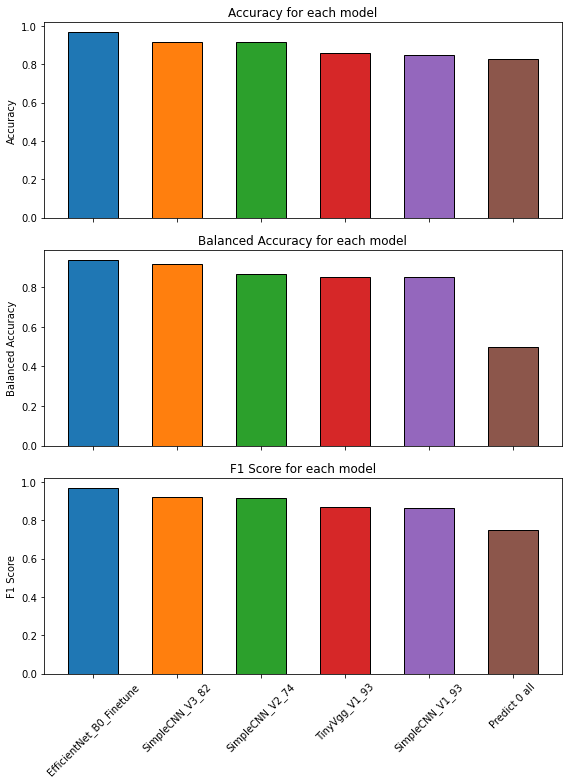

In [98]:
# Create bar plot
n_models = len(final_results)
fig, ax = plt.subplots(3, 1, figsize=(8, 11), sharex=True)
index = np.arange(n_models)
bar_width = 0.6
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']


ax[0].bar(index, final_results.sort_values('F1 Score', ascending=False)['Accuracy'], bar_width, color = colors, edgecolor='black', label="Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy for each model")

ax[1].bar(index, final_results.sort_values('F1 Score', ascending=False)['Balanced Accuracy'], bar_width, color = colors, edgecolor='black',label="Balanced Accuracy")
ax[1].set_ylabel("Balanced Accuracy")
ax[1].set_title("Balanced Accuracy for each model")

ax[2].bar(index, final_results.sort_values('F1 Score', ascending=False)['F1 Score'], bar_width, color = colors, edgecolor='black', label="F1 Score")
ax[2].set_ylabel("F1 Score")
ax[2].set_title("F1 Score for each model")

plt.xticks(index, final_results.sort_values('F1 Score', ascending=False)['Model Name'], rotation=45)
plt.tight_layout()
plt.show()